## Bayesian Spatiotemporal Binomial GFL example in 3D grid

In [1]:
using Pkg; Pkg.activate(".");
using Statistics
using StatsFuns
using LinearAlgebra
using Distributions
using Colors
using ProgressMeter
using Base.Threads
include("src/AdaptiveRejectionSampling2.jl")
using Plots; default(fmt = :png)

 Activating environment at `C:\Users\mauri\Github\BayesianGFL\Project.toml`


### Gibbs sampler code

Below is all the code for the gibbs sampler. It uses an Adaptive Rejection Sampler which samples very efficiently from any scalar distribution with convex loglikelihoods. The code uses asynchronous parallel updates.

See the code here for the sampler: https://github.com/mauriciogtec/AdaptiveRejectionSampling.jl

In [2]:
zeros_like(x) = zeros(size(x))

function binomial_gibbs_step(
    s::Float64,  # successes
    a::Float64,  # attempts
    nbr_values::Vector{Float64} = [],  # values of neighbors
    ;
    λ_tv1::Vector{Float64} = zeros_like(nbr_values),  # edge penalties l1
    λ_tv2::Vector{Float64} = zeros_like(nbr_values),  # edge penalties l2
    λ_lasso::Float64 = 0.0,  # l1 reg
    λ_ridge::Float64 = 0.0,  # l2 reg
)::Float64 
    # add a small constant for numerical stability
    ϵ = 1e-8
    a = a + 2ϵ
    s = s + ϵ
    n_nbrs =  length(nbr_values)
    
    # define target loglikelihood, any target is ok as long as it is concave
    # and it is easy to provide one point with positive and negative slope
    target_dens(θ) = begin
        logll = if θ >= 0
            - a * log(1.0 + exp(-θ)) - (a - s) * θ
        else
            s * θ - a * log(1.0 + exp(θ))
        end
        if n_nbrs > 0
            tv1 = dot(abs.(θ .- nbr_values), λ_tv1)
            tv2 = dot((θ .- nbr_values).^2, λ_tv2)
        else
            tv1 = 0.0
            tv2 = 0.0
        end
        lasso_reg = λ_lasso * abs(θ)
        ridge_reg = λ_ridge * θ^2
        logll - tv1 - tv2 - lasso_reg - ridge_reg
    end
    
    # it's easy to define points with positive and negative slopes
    # based on the minimum and max posible values
    # efficiency of the sample increase with good envelope points
    envelope_init = (
        min(logit(s / a),  minimum(nbr_values)) - 1e-6,
        max(logit(s / a), maximum(nbr_values)) + 1e-6
    )
 
    # build sampler
    support = (-Inf, Inf)
    sampler = RejectionSampler(
        target_dens, support, envelope_init, max_segments=10, from_log=true
    )
    
    # return one sample
    run_sampler!(sampler, 1)[1]
end 


function binomial_gibbs_sweep(
    θ::Vector{Float64},  # current
    s::Vector{Float64},  # successes
    a::Vector{Float64},  # attempts
    nbrs::Vector{Vector{Int}} # neighbors
    ;
    λ_tv1::Vector{Vector{Float64}} = [zeros_like(x) for x in nbrs],
    λ_tv2::Vector{Vector{Float64}} = [zeros_like(x) for x in nbrs],
    λ_lasso::Vector{Float64} = zeros_like(s),
    λ_ridge::Vector{Float64} = zeros_like(s)
)
    T = length(θ)
    θnew = zeros(Float64, T)
    
    # async updates using multiple threads
    @inbounds @threads for t in 1:T
        nbr_values = [θ[i] for i in nbrs[t]]
        θnew[t] = binomial_gibbs_step(
            s[t],
            a[t],
            nbr_values,
            λ_tv1=λ_tv1[t],
            λ_tv2=λ_tv2[t],
            λ_lasso=λ_lasso[t],
            λ_ridge=λ_ridge[t]
        )
    end
    return θnew
end


function binomial_bayesian_gfl(
    s::Vector{Float64},  # successes
    a::Vector{Float64},  # attempts
    nbrs::Vector{Vector{Int}},
    n::Int  # chain iterations (full sweeps),
    ;
    λ_tv1::Vector{Vector{Float64}} = [zeros_like(x) for x in nbrs],
    λ_tv2::Vector{Vector{Float64}} = [zeros_like(x) for x in nbrs],
    λ_lasso::Vector{Float64} = zeros_like(s),
    λ_ridge::Vector{Float64} = zeros_like(s),
    θ₀::Vector{Float64} = zeros_like(s)  # initial values for chain
)
    # store each gibbs sweep in matrix
    θ = zeros(length(s), n + 1)
    θ[:, 1] = θ₀
    @showprogress for i in 1:n
        θ[:, i + 1] = binomial_gibbs_sweep(
            θ[:, i],
            s,
            a,
            nbrs,
            λ_tv1=λ_tv1,
            λ_tv2=λ_tv2,
            λ_lasso=λ_lasso,
            λ_ridge=λ_ridge
        )
    end
    return θ
end

binomial_bayesian_gfl (generic function with 1 method)

### Data

The code below simulates from a Binomial distribution spatially arranged probablities (0.7 or 0.3) and with a random number of observations (1 or 5) to inject noise.

In [3]:
nr = 61
nc = 61
nk = 30

grid = zeros(nr, nc, nk)
s = zeros(nr, nc, nk)
a = zeros(nr, nc, nk)

for k in 1:nk
    for j in 1:nc
        for i in 1:nr
            b = Float64((i - (nr / 2)) * (j - (nc / 2)) * (k - nk / 2) ≥ 0)
            δk = (0.5 / nk) * (k ÷ (nk ÷ 5))
            grid[i, j, k] = 0.7 * b + 0.3 * (1 - b)
            a[i, j, k] = rand([1, 5.])
            s[i, j, k] = rand(Binomial(a[i, j, k], grid[i, j, k]))
        end
    end
end



# build graph
nbrs = Vector{Int}[]
index_map = reshape(1:(nr * nc * nk), (nr, nc, nk));
λ_tv1 = Vector{Float64}[]
λ_tv2 = Vector{Float64}[]
for k in 1:nk
    for j in 1:nc
        for i in 1:nr
            nbrs_ = Int[]
            (i > 1) && push!(nbrs_, index_map[i - 1, j, k])
            (i < nr) && push!(nbrs_, index_map[i + 1, j, k])
            (j > 1) && push!(nbrs_, index_map[i, j - 1, k])
            (j < nc) && push!(nbrs_, index_map[i, j + 1, k])
            (k > 1) && push!(nbrs_, index_map[i, j, k - 1])
            (k < nk) && push!(nbrs_, index_map[i, j, k + 1])
            push!(nbrs, nbrs_)
            push!(λ_tv1, 2.5 * ones(length(nbrs_)))
            push!(λ_tv2, 0.0 * ones(length(nbrs_)))
        end
    end
end
s_vec = vec(s);
a_vec = vec(a);

In [4]:
print("Graph with $(length(vec(grid))) nodes and $(sum([length(x) for x in nbrs]) ÷ 2) edges")

Graph with 111630 nodes and 327509 edges

┌ Info: Saved animation to 
│   fn = C:\Users\mauri\Github\BayesianGFL\grid.gif
└ @ Plots C:\Users\mauri\.julia\packages\Plots\cc8wh\src\animation.jl:98


Plots.AnimatedGif("C:\\Users\\mauri\\Github\\BayesianGFL\\grid.gif")
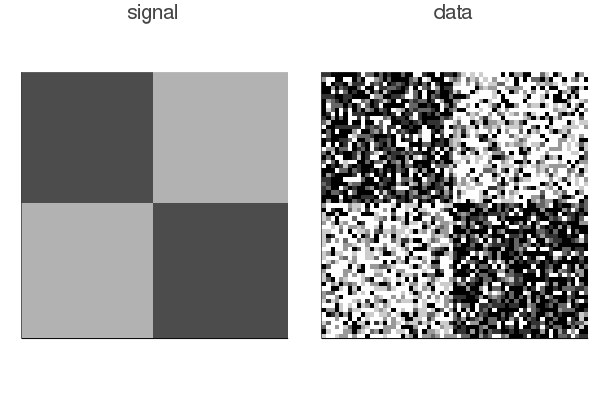

In [5]:
data = ((s .+ 1e-6) ./ (a .+ 2e-6))

anim = @animate for k in 1:nk
    p1 = plot(Gray.(grid[:, :, k]), title="signal")
    p2 = plot(Gray.(data[:, :, k]), title="data")
    plot(p1, p2, axis=nothing, layout=(1, 2), figsize=(500, 250))
end
gif(anim, "grid.gif", fps = 15)

### Results

The chain mixing looks pretty good. It takes about 2h to run in personal computer. Although it seems like mixing is pretty good from start. It is somewhat easy problem though.

In [6]:
N = 2_500
@time chain = binomial_bayesian_gfl(s_vec, a_vec, nbrs, N, λ_tv1=λ_tv1, λ_tv2=λ_tv2);

Progress: 100%|█████████████████████████████████████████| Time: 0:33:56


2037.330822 seconds (66.55 G allocations: 2.154 TiB, 41.12% gc time)


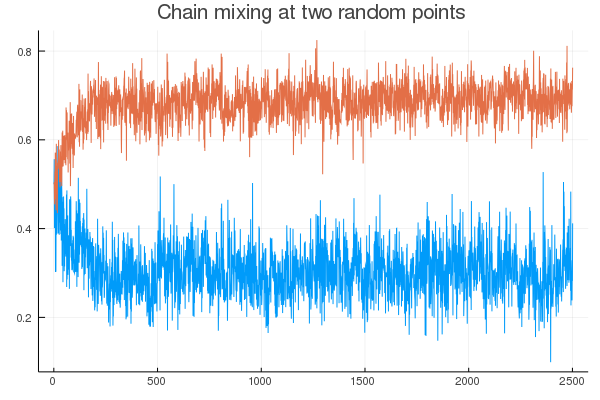

In [7]:
plot(logistic.(chain[[1, 3000], :]'), lab="", title="Chain mixing at two random points")

In [8]:
burnin = N - 1250
m = median(logistic.(chain[:, burnin + 1:end]), dims=2)
m = reshape(vec(m), (nr, nc, nk));
iqrv = [iqr(logistic.(chain[i, burnin + 1:end])) for i in 1:(nr * nc * nk)]
iqrv = (iqrv .- minimum(iqrv)) ./ (maximum(iqrv) - minimum(iqrv))
iqrv = reshape(iqrv, (nr, nc, nk));

It's actually very cool to look at the posterior IQR. There is more uncertainty in the intersections.

┌ Info: Saved animation to 
│   fn = C:\Users\mauri\Github\BayesianGFL\solution.gif
└ @ Plots C:\Users\mauri\.julia\packages\Plots\cc8wh\src\animation.jl:98


Plots.AnimatedGif("C:\\Users\\mauri\\Github\\BayesianGFL\\solution.gif")
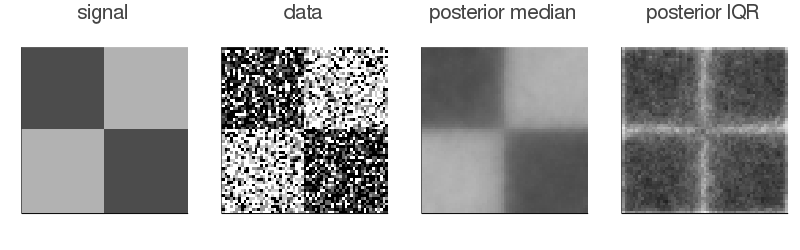

In [9]:
anim = @animate for k in 1:nk
    p1 = plot(Gray.(grid[:, :, k]), title="signal")
    p2 = plot(Gray.(data[:, :, k]), title="data")
    p3 = plot(Gray.(m[:, :, k]), title="posterior median")
    p4 = plot(Gray.(iqrv[:, :, k]), title="posterior IQR")
    plot(p1, p2, p3, p4, layout=(1, 4), size=(800, 250), axis=nothing)
end
gif(anim, "solution.gif", fps = 15)